<a href="https://colab.research.google.com/github/Advanced-Data-Science-TU-Berlin/Part-2/blob/main/notebooks/5_2_social_graph_communities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Massive Graphs - Marvel Universe
In this exercise we will be using a dataset from the comics and movies associated with the Marvel Universe. This dataset can be found [here](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network). It contains 40,616 characters and 65,870 relationships connecting them. We will be using this dataset to discover its hidden characteristics, how the different characters influenced each other and their communities structure.

## About DataSet
The Marvel dataset is composed of a list of co-occurrences of super heros. For example, every time Spider Man appears in a comic book with Captain America, we will have a line with both their names. Additionally, the characters have numerous properties that can be associated with each node.
The dataset is divided into three files:
- nodes.csv: Contains two columns (node, type), indicating the name and the type (comic, hero) of the nodes.
- edges.csv: Contains two columns (hero, comic), indicating in which comics the heroes appear.
- hero-edge.csv: Contains the network of heroes which appear together in the comics. This file was originally taken from http://syntagmatic.github.io/exposedata/marvel/

First, let's download the dataset and look at some samples from the data:

In [ ]:
!pip install opendatasets
!pip install pyvis

  Created wheel for pyvis: filename=pyvis-0.2.1-py3-none-any.whl size=23688 sha256=3951fc3119181b909df82bb3e4e9e35ab9beb2e2d5d70b3619d656a80fcdc132
  Stored in directory: /root/.cache/pip/wheels/2a/8f/04/6340d46afc74f59cc857a594ca1a2a14a1f4cbd4fd6c2e9306
Successfully built pyvis


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahnaznmz
Your Kaggle Key: ··········


100%|██████████| 2.72M/2.72M [00:00<00:00, 157MB/s]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
% matplotlib inline

nodes_df = pd.read_csv("/content/the-marvel-universe-social-network/nodes.csv")
edges_df = pd.read_csv("/content/the-marvel-universe-social-network/edges.csv")
hero_net_df = pd.read_csv("/content/the-marvel-universe-social-network/hero-network.csv")
print("Sample Nodes:------------------------")
display(nodes_df.head())
print("Sample Edges:------------------------")
display(edges_df.head())
print("Sample Heros Network:----------------")
display(hero_net_df.head())

Sample Nodes:------------------------


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


Sample Edges:------------------------


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


Sample Heros Network:----------------


,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


Now let's use this data to construct an undirected graph and look at some of its basic statistics:

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(hero_net_df,
                            source='hero1',
                            target='hero2',
                            create_using=nx.Graph())


In [ ]:
# Graph statistics
print("Number of edges:", G.size()) # alternative: nx.number_of_edges(G)
print("Number of nodes:", G.order()) # alternative: nx.number_of_nodes(G)
# The density for undirected graphs is d = 2m / (n(n-1)), where n is
# the number of nodes and m is the number of edges
print("Network Density:", nx.density(G))

Number of edges: 167219
Number of nodes: 6426
Network Diameter: 0.00810031232553549


As we can see out network is not quite dense but rather sparse.

Let's use the graph structure to answer several questions.


### Q1. Who is the most friendly superhero?
We can translate this question to `who is the superhero with the highest number of friends?`. If we wanted to answer this question using DataFrame, it wouldn't be trivial because for each hero we would need to count the number of distinct friends both when the hero appears in the Hero1 column and the Hero2 column. However, answering this question using a graph object is relatively easy; we simply need to find the node with the maximal degree.

In [ ]:
# Getting each node's degree
d = G.degree()
# Sorting the nodes with highest degree. Let's take top-5
display(sorted(d, key=lambda x: x[1], reverse=True)[:5])

[('CAPTAIN AMERICA', 1908),
 ('SPIDER-MAN/PETER PAR', 1737),
 ('IRON MAN/TONY STARK ', 1522),
 ('THING/BENJAMIN J. GR', 1416),
 ('MR. FANTASTIC/REED R', 1379)]

So, using the degree, we discovered that the `most friendly` superhero is `Captain America` who is connected to 1908 heroes.

Let's use seaborn to calculate the graph degree distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Degree')

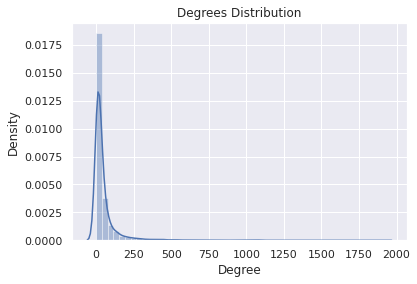

In [ ]:
fig, ax = plt.subplots()
sns.set()
sns.distplot([v for v in dict(d).values()], ax=ax)
ax.set_title('Degrees Distribution')
ax.set_xlabel('Degree')
# ax_ = ax.twinx()
# ax_.plot(range(len(nx.degree_histogram(G))), np.cumsum(nx.degree_histogram(G))/G.order())

From the above plot, we can see that many nodes have low degrees, i.e. these heroes are connected to only a few heros. Let's create a subgraph without these nodes:

In [ ]:
# let's create a list with nodes that have degree > 50
selected_nodes_list = [n for n, d in dict(d).items() if d > 50]
# create a subgraph with only nodes from the above list
sub_G = G.subgraph(selected_nodes_list)
print(nx.info(sub_G))

Graph with 1483 nodes and 92823 edges


As we can see, we could reduce the size of the graph.
### Q2: What is the largest community in the graph?
Among the wonderful things that are useful using graphs as data structures is the ability to separate them into communities, i.e., disjoint subgraphs. Let's use [Clauset-Newman-Moore greedy modularity maximization](https://arxiv.org/abs/cond-mat/0408187) to separate the graph into communities.

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
# Apply the Community Detection Algorithm [be patient this can take a while]
cc = greedy_modularity_communities(sub_G)
len(cc)

6

Using the community detection algorithm, we detected 6 communities of different sizes. Let's view the size of the distribution of the community sizes:

Text(0, 0.5, '#Nodes')

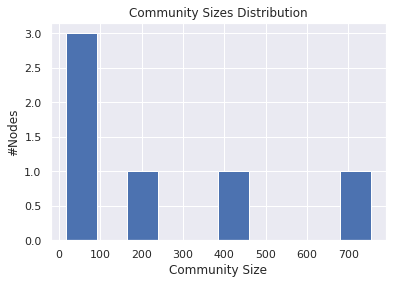

In [ ]:
community_size_list = [len(c) for c in cc]
fig, ax = plt.subplots()
ax.hist(community_size_list)
ax.set_title("Community Sizes Distribution")
ax.set_xlabel("Community Size")
ax.set_ylabel("#Nodes")

We can see that 2 communities are relatively smaller than others. Let's take a look at this two communities:

In [ ]:
selected_community_list = [c for c in cc if len(c)<50]
len(selected_community_list)

2

Let's plot both communities with a helper function

In [ ]:
from IPython.core.display import display, HTML # We need this because of colab
# Import pyvis
from pyvis.network import Network
def plot_subgraph(g, nodes_list, title):
  sub_g = g.subgraph(nodes_list)
  # Create vis network
  net = Network(height="700px", width="75%", notebook=True)
  # Now load the networkx graph into the vis network
  net.force_atlas_2based()
  net.show_buttons(filter_=['physics']) 
  net.from_nx(sub_g, default_node_size=20)
  # Let's visualize the network using pyvis
  net.show(f"{title}.html")
  display(HTML(f"{title}.html"))

In [ ]:
plot_subgraph(sub_G, selected_community_list[0], title='Community-1')